In [1]:
import warnings
from operator import itemgetter
import numpy as np
from scipy.linalg import cholesky, cho_solve, solve_triangular
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_X_y, check_array
from sklearn.utils.deprecation import deprecated

In [2]:
class GaussianProcessRegressor(BaseEstimator, RegressorMixin):
    """Gaussian process regression (GPR).
    The implementation is based on Algorithm 2.1 of Gaussian Processes
    for Machine Learning (GPML) by Rasmussen and Williams.
    In addition to standard scikit-learn estimator API,
    GaussianProcessRegressor:
       * allows prediction without prior fitting (based on the GP prior)
       * provides an additional method sample_y(X), which evaluates samples
         drawn from the GPR (prior or posterior) at given inputs
       * exposes a method log_marginal_likelihood(theta), which can be used
         externally for other ways of selecting hyperparameters, e.g., via
         Markov chain Monte Carlo.
    Read more in the :ref:`User Guide <gaussian_process>`.
    .. versionadded:: 0.18
    Parameters
    ----------
    kernel : kernel object
        The kernel specifying the covariance function of the GP. If None is
        passed, the kernel "1.0 * RBF(1.0)" is used as default. Note that
        the kernel's hyperparameters are optimized during fitting.
    alpha : float or array-like, optional (default: 1e-10)
        Value added to the diagonal of the kernel matrix during fitting.
        Larger values correspond to increased noise level in the observations.
        This can also prevent a potential numerical issue during fitting, by
        ensuring that the calculated values form a positive definite matrix.
        If an array is passed, it must have the same number of entries as the
        data used for fitting and is used as datapoint-dependent noise level.
        Note that this is equivalent to adding a WhiteKernel with c=alpha.
        Allowing to specify the noise level directly as a parameter is mainly
        for convenience and for consistency with Ridge.
    optimizer : string or callable, optional (default: "fmin_l_bfgs_b")
        Can either be one of the internally supported optimizers for optimizing
        the kernel's parameters, specified by a string, or an externally
        defined optimizer passed as a callable. If a callable is passed, it
        must have the signature::
            def optimizer(obj_func, initial_theta, bounds):
                # * 'obj_func' is the objective function to be maximized, which
                #   takes the hyperparameters theta as parameter and an
                #   optional flag eval_gradient, which determines if the
                #   gradient is returned additionally to the function value
                # * 'initial_theta': the initial value for theta, which can be
                #   used by local optimizers
                # * 'bounds': the bounds on the values of theta
                ....
                # Returned are the best found hyperparameters theta and
                # the corresponding value of the target function.
                return theta_opt, func_min
        Per default, the 'fmin_l_bfgs_b' algorithm from scipy.optimize
        is used. If None is passed, the kernel's parameters are kept fixed.
        Available internal optimizers are::
            'fmin_l_bfgs_b'
    n_restarts_optimizer : int, optional (default: 0)
        The number of restarts of the optimizer for finding the kernel's
        parameters which maximize the log-marginal likelihood. The first run
        of the optimizer is performed from the kernel's initial parameters,
        the remaining ones (if any) from thetas sampled log-uniform randomly
        from the space of allowed theta-values. If greater than 0, all bounds
        must be finite. Note that n_restarts_optimizer == 0 implies that one
        run is performed.
    normalize_y : boolean, optional (default: False)
        Whether the target values y are normalized, i.e., the mean of the
        observed target values become zero. This parameter should be set to
        True if the target values' mean is expected to differ considerable from
        zero. When enabled, the normalization effectively modifies the GP's
        prior based on the data, which contradicts the likelihood principle;
        normalization is thus disabled per default.
    copy_X_train : bool, optional (default: True)
        If True, a persistent copy of the training data is stored in the
        object. Otherwise, just a reference to the training data is stored,
        which might cause predictions to change if the data is modified
        externally.
    random_state : int, RandomState instance or None, optional (default: None)
        The generator used to initialize the centers. If int, random_state is
        the seed used by the random number generator; If RandomState instance,
        random_state is the random number generator; If None, the random number
        generator is the RandomState instance used by `np.random`.
    Attributes
    ----------
    X_train_ : array-like, shape = (n_samples, n_features)
        Feature values in training data (also required for prediction)
    y_train_ : array-like, shape = (n_samples, [n_output_dims])
        Target values in training data (also required for prediction)
    kernel_ : kernel object
        The kernel used for prediction. The structure of the kernel is the
        same as the one passed as parameter but with optimized hyperparameters
    L_ : array-like, shape = (n_samples, n_samples)
        Lower-triangular Cholesky decomposition of the kernel in ``X_train_``
    alpha_ : array-like, shape = (n_samples,)
        Dual coefficients of training data points in kernel space
    log_marginal_likelihood_value_ : float
        The log-marginal-likelihood of ``self.kernel_.theta``
    """
    def __init__(self, kernel=None, alpha=1e-10,
                 optimizer="fmin_l_bfgs_b", n_restarts_optimizer=0,
                 normalize_y=False, copy_X_train=True, random_state=None):
        self.kernel = kernel
        self.alpha = alpha
        self.optimizer = optimizer
        self.n_restarts_optimizer = n_restarts_optimizer
        self.normalize_y = normalize_y
        self.copy_X_train = copy_X_train
        self.random_state = random_state


    def y_train_mean(self):
        return self._y_train_mean

    def fit(self, X, y):
        """Fit Gaussian process regression model.
        Parameters
        ----------
        X : array-like, shape = (n_samples, n_features)
            Training data
        y : array-like, shape = (n_samples, [n_output_dims])
            Target values
        Returns
        -------
        self : returns an instance of self.
        """
        if self.kernel is None:  # Use an RBF kernel as default
            self.kernel_ = C(1.0, constant_value_bounds="fixed") \
                * RBF(1.0, length_scale_bounds="fixed")
        else:
            self.kernel_ = clone(self.kernel)

        self._rng = check_random_state(self.random_state)

        X, y = check_X_y(X, y, multi_output=True, y_numeric=True)

        # Normalize target value
        if self.normalize_y:
            self._y_train_mean = np.mean(y, axis=0)
            # demean y
            y = y - self._y_train_mean
        else:
            self._y_train_mean = np.zeros(1)

        if np.iterable(self.alpha) \
           and self.alpha.shape[0] != y.shape[0]:
            if self.alpha.shape[0] == 1:
                self.alpha = self.alpha[0]
            else:
                raise ValueError("alpha must be a scalar or an array"
                                 " with same number of entries as y.(%d != %d)"
                                 % (self.alpha.shape[0], y.shape[0]))

        self.X_train_ = np.copy(X) if self.copy_X_train else X
        self.y_train_ = np.copy(y) if self.copy_X_train else y

        if self.optimizer is not None and self.kernel_.n_dims > 0:
            # Choose hyperparameters based on maximizing the log-marginal
            # likelihood (potentially starting from several initial values)
            def obj_func(theta, eval_gradient=True):
                if eval_gradient:
                    lml, grad = self.log_marginal_likelihood(
                        theta, eval_gradient=True)
                    return -lml, -grad
                else:
                    return -self.log_marginal_likelihood(theta)

            # First optimize starting from theta specified in kernel
            optima = [(self._constrained_optimization(obj_func,
                                                      self.kernel_.theta,
                                                      self.kernel_.bounds))]

            # Additional runs are performed from log-uniform chosen initial
            # theta
            if self.n_restarts_optimizer > 0:
                if not np.isfinite(self.kernel_.bounds).all():
                    raise ValueError(
                        "Multiple optimizer restarts (n_restarts_optimizer>0) "
                        "requires that all bounds are finite.")
                bounds = self.kernel_.bounds
                for iteration in range(self.n_restarts_optimizer):
                    theta_initial = \
                        self._rng.uniform(bounds[:, 0], bounds[:, 1])
                    optima.append(
                        self._constrained_optimization(obj_func, theta_initial,
                                                       bounds))
            # Select result from run with minimal (negative) log-marginal
            # likelihood
            lml_values = list(map(itemgetter(1), optima))
            self.kernel_.theta = optima[np.argmin(lml_values)][0]
            self.log_marginal_likelihood_value_ = -np.min(lml_values)
        else:
            self.log_marginal_likelihood_value_ = \
                self.log_marginal_likelihood(self.kernel_.theta)

        # Precompute quantities required for predictions which are independent
        # of actual query points
        K = self.kernel_(self.X_train_)
        K[np.diag_indices_from(K)] += self.alpha
        try:
            self.L_ = cholesky(K, lower=True)  # Line 2
        except np.linalg.LinAlgError as exc:
            exc.args = ("The kernel, %s, is not returning a "
                        "positive definite matrix. Try gradually "
                        "increasing the 'alpha' parameter of your "
                        "GaussianProcessRegressor estimator."
                        % self.kernel_,) + exc.args
            raise
        self.alpha_ = cho_solve((self.L_, True), self.y_train_)  # Line 3
        return self

    def predict(self, X, return_std=False, return_cov=False):
        """Predict using the Gaussian process regression model
        We can also predict based on an unfitted model by using the GP prior.
        In addition to the mean of the predictive distribution, also its
        standard deviation (return_std=True) or covariance (return_cov=True).
        Note that at most one of the two can be requested.
        Parameters
        ----------
        X : array-like, shape = (n_samples, n_features)
            Query points where the GP is evaluated
        return_std : bool, default: False
            If True, the standard-deviation of the predictive distribution at
            the query points is returned along with the mean.
        return_cov : bool, default: False
            If True, the covariance of the joint predictive distribution at
            the query points is returned along with the mean
        Returns
        -------
        y_mean : array, shape = (n_samples, [n_output_dims])
            Mean of predictive distribution a query points
        y_std : array, shape = (n_samples,), optional
            Standard deviation of predictive distribution at query points.
            Only returned when return_std is True.
        y_cov : array, shape = (n_samples, n_samples), optional
            Covariance of joint predictive distribution a query points.
            Only returned when return_cov is True.
        """
        if return_std and return_cov:
            raise RuntimeError(
                "Not returning standard deviation of predictions when "
                "returning full covariance.")
#         try:
#             X = check_array(X)
#         except:
            

        if not hasattr(self, "X_train_"):  # Unfitted;predict based on GP prior
            if self.kernel is None:
                kernel = (C(1.0, constant_value_bounds="fixed") *
                          RBF(1.0, length_scale_bounds="fixed"))
            else:
                kernel = self.kernel
            y_mean = np.zeros(X.shape[0])
            if return_cov:
                y_cov = kernel(X)
                return y_mean, y_cov
            elif return_std:
                y_var = kernel.diag(X)
                return y_mean, np.sqrt(y_var)
            else:
                return y_mean
        else:  # Predict based on GP posterior
            K_trans = self.kernel_(X, self.X_train_)
            y_mean = K_trans.dot(self.alpha_)  # Line 4 (y_mean = f_star)
            y_mean = self._y_train_mean + y_mean  # undo normal.
            if return_cov:
                v = cho_solve((self.L_, True), K_trans.T)  # Line 5
                y_cov = self.kernel_(X) - K_trans.dot(v)  # Line 6
                return y_mean, y_cov
            elif return_std:
                # compute inverse K_inv of K based on its Cholesky
                # decomposition L and its inverse L_inv
                L_inv = solve_triangular(self.L_.T, np.eye(self.L_.shape[0]))
                K_inv = L_inv.dot(L_inv.T)
                # Compute variance of predictive distribution
                y_var = self.kernel_.diag(X)
                y_var -= np.einsum("ij,ij->i", np.dot(K_trans, K_inv), K_trans)

                # Check if any of the variances is negative because of
                # numerical issues. If yes: set the variance to 0.
                y_var_negative = y_var < 0
                if np.any(y_var_negative):
                    warnings.warn("Predicted variances smaller than 0. "
                                  "Setting those variances to 0.")
                    y_var[y_var_negative] = 0.0
                return y_mean, np.sqrt(y_var)
            else:
                return y_mean

    def sample_y(self, X, n_samples=1, random_state=0):
        """Draw samples from Gaussian process and evaluate at X.
        Parameters
        ----------
        X : array-like, shape = (n_samples_X, n_features)
            Query points where the GP samples are evaluated
        n_samples : int, default: 1
            The number of samples drawn from the Gaussian process
        random_state : int, RandomState instance or None, optional (default=0)
            If int, random_state is the seed used by the random number
            generator; If RandomState instance, random_state is the
            random number generator; If None, the random number
            generator is the RandomState instance used by `np.random`.
        Returns
        -------
        y_samples : array, shape = (n_samples_X, [n_output_dims], n_samples)
            Values of n_samples samples drawn from Gaussian process and
            evaluated at query points.
        """
        rng = check_random_state(random_state)

        y_mean, y_cov = self.predict(X, return_cov=True)
        if y_mean.ndim == 1:
            y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T
        else:
            y_samples = \
                [rng.multivariate_normal(y_mean[:, i], y_cov,
                                         n_samples).T[:, np.newaxis]
                 for i in range(y_mean.shape[1])]
            y_samples = np.hstack(y_samples)
        return y_samples

    def log_marginal_likelihood(self, theta=None, eval_gradient=False):
        """Returns log-marginal likelihood of theta for training data.
        Parameters
        ----------
        theta : array-like, shape = (n_kernel_params,) or None
            Kernel hyperparameters for which the log-marginal likelihood is
            evaluated. If None, the precomputed log_marginal_likelihood
            of ``self.kernel_.theta`` is returned.
        eval_gradient : bool, default: False
            If True, the gradient of the log-marginal likelihood with respect
            to the kernel hyperparameters at position theta is returned
            additionally. If True, theta must not be None.
        Returns
        -------
        log_likelihood : float
            Log-marginal likelihood of theta for training data.
        log_likelihood_gradient : array, shape = (n_kernel_params,), optional
            Gradient of the log-marginal likelihood with respect to the kernel
            hyperparameters at position theta.
            Only returned when eval_gradient is True.
        """
        if theta is None:
            if eval_gradient:
                raise ValueError(
                    "Gradient can only be evaluated for theta!=None")
            return self.log_marginal_likelihood_value_

        kernel = self.kernel_.clone_with_theta(theta)

        if eval_gradient:
            K, K_gradient = kernel(self.X_train_, eval_gradient=True)
        else:
            K = kernel(self.X_train_)

        K[np.diag_indices_from(K)] += self.alpha
        try:
            L = cholesky(K, lower=True)  # Line 2
        except np.linalg.LinAlgError:
            return (-np.inf, np.zeros_like(theta)) \
                if eval_gradient else -np.inf

        # Support multi-dimensional output of self.y_train_
        y_train = self.y_train_
        if y_train.ndim == 1:
            y_train = y_train[:, np.newaxis]

        alpha = cho_solve((L, True), y_train)  # Line 3

        # Compute log-likelihood (compare line 7)
        log_likelihood_dims = -0.5 * np.einsum("ik,ik->k", y_train, alpha)
        log_likelihood_dims -= np.log(np.diag(L)).sum()
        log_likelihood_dims -= K.shape[0] / 2 * np.log(2 * np.pi)
        log_likelihood = log_likelihood_dims.sum(-1)  # sum over dimensions

        if eval_gradient:  # compare Equation 5.9 from GPML
            tmp = np.einsum("ik,jk->ijk", alpha, alpha)  # k: output-dimension
            tmp -= cho_solve((L, True), np.eye(K.shape[0]))[:, :, np.newaxis]
            # Compute "0.5 * trace(tmp.dot(K_gradient))" without
            # constructing the full matrix tmp.dot(K_gradient) since only
            # its diagonal is required
            log_likelihood_gradient_dims = \
                0.5 * np.einsum("ijl,ijk->kl", tmp, K_gradient)
            log_likelihood_gradient = log_likelihood_gradient_dims.sum(-1)

        if eval_gradient:
            return log_likelihood, log_likelihood_gradient
        else:
            return log_likelihood

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            theta_opt, func_min, convergence_dict = \
                fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds)
            if convergence_dict["warnflag"] != 0:
                warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
                              " state: %s" % convergence_dict)
        elif callable(self.optimizer):
            theta_opt, func_min = \
                self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)

        return theta_opt, func_min
    
    def mu_grad(self, x):
        
        mu = lambda x: self.predict(x)
        auto_grad = autograd.grad(mu)
        return auto_grad(x)

X training data: (30, 1)
X testing data: (100, 1)


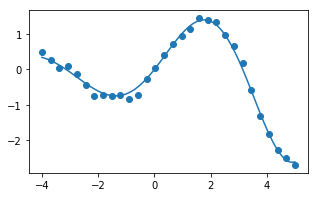

In [3]:
# get some toy data
d_dimensions = 1
n_samples = 20
noise_std = 0.1
seed = 123
rs = np.random.RandomState(seed)

n_train = 30
n_test = 100
xtrain = np.linspace(-4, 5, n_train).reshape(n_train, 1)
xtest = np.linspace(-4, 5, n_test).reshape(n_test, 1)
print('X training data:', xtrain.shape)
print('X testing data:', xtest.shape)


# Labels
f = lambda x: np.sin(x) * np.exp(0.2 * x)
ytrain = f(xtrain) + noise_std * np.random.randn(n_train, 1)
ytest = f(xtest)
# Plot the function
fig, ax = plt.subplots(figsize=(5, 3))

ax.scatter(xtrain, ytrain)
ax.plot(xtest, ytest)

plt.show()

In [31]:
# Initialize the model
kernel = RBF() + WhiteKernel()
gp_model = GaussianProcessRegressor(kernel=kernel, random_state=seed)

# fit the gp model to the inputs and targets
gp_model.fit(xtrain, ytrain)

print(gp_model.kernel_)
y_pred, sigma = gp_model.predict(xtest, return_std=True)
mu_grad = gp_model.mu_grad(xtest)
fig, ax = plt.subplots()

# ax.scatter(xtrain, ytrain)
ax.scatter(xtrain, ytrain)
ax.plot(xtest, y_pred)
ax.plot(xtest, ytest)
plt.show()

RBF(length_scale=1.59) + WhiteKernel(noise_level=0.00678)


ValueError: setting an array element with a sequence.